# Laborator 6 - Segmentare Semantică

În acest laborator veți construi și antrena o rețea complet convoluțională (***FCN - Fully Convolutional Network***), al cărei rezultat este o imagine (nu doar o clasificare). Veți implementa trei tehnici speciale: ***convoluții 1x1***, ***upsampling*** și ***skip layers*** pentru a vă antrena propriul FCN.

Veți începe de la un model pre-antrenat pe ImageNet (***VGG16***). După eliminarea straturilor de clasificare (fully connected layers), veți putea adăuga cele trei tehnici (conv. 1x1, upsampling și skip layers) pentru a obține un FCN capabil să clasifice fiecare pixel din imagine.

Veți construi o rețea de segmentare semantică pentru a identifica spațiul liber pe drum (veți folosi setul de date [Kitti Road](http://www.cvlibs.net/datasets/kitti/eval_road.php)).

## De ce FCN?

O rețea convoluțională normală constă dintr-o serie de straturi convoluționale, urmată de straturi fully connected și, în cele din urmă, de o funcție de activare Softmax. Aceasta este o arhitectură bună pentru clasificare, însă straturile fully connected nu păstrează informația spațială. FCN păstrează informația spațială în întreaga rețea (FCN funcționează cu imagini de orice dimensiune).

Din punct de vedere structural, FCN este compusă din două părți: encoder (VGG, ResNet - extrage caracteristici din imagine) și decoder (mărește outputul encoderului pentru a fi de aceeași dimensiune ca imaginea originală; astfel, se realizează clasificarea fiecărui pixel individual din imaginea originală)

---

![alt text](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/05d20ad124a8696f387e6c9632dec0b31251df64/4-Figure3-1.png)

In [0]:
from google.colab import files
uploaded = files.upload()
print("OK")

Saving helper.py to helper (2).py
Saving project_tests.py to project_tests (2).py
OK


In [0]:
# Install dependencies
!apt-get update
!apt-get install ffmpeg
!pip install moviepy tqdm

# Download & Extract the Kitti Road dataset
!mkdir ./data ./runs ./saved_models
!wget --progress=bar:force https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip -P ./data
!unzip ./data/data_road.zip -d ./data

In [0]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests

from moviepy.editor import VideoFileClip
import scipy.misc
import numpy as np

import sys

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob
import random

In [0]:
# Descărcați modelul VGG pre-antrenat

num_classes = 2
image_shape = (160, 576)
data_dir = './data'
runs_dir = './runs'

helper.maybe_download_pretrained_vgg(data_dir)
tests.test_for_kitti_dataset(data_dir)

Tests Passed


### Vizualizare dataset Kitti Road

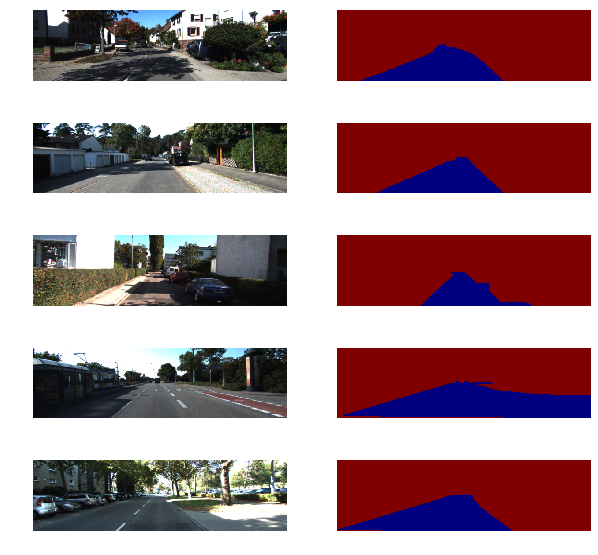

In [0]:
num_samples = 5
get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

plt.figure(figsize=(10, 10))

for batch, (images, labels) in enumerate(get_batches_fn(num_samples)):
  for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(num_samples, 2, 2*i+1)
    plt.axis('off')
    plt.imshow(image, None)
    plt.subplot(num_samples, 2, 2*i+2)
    plt.axis('off')
    plt.imshow(label[:,:,0], 'jet')
    
  break

In [0]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.13.1


In [0]:
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


## Cerința 1 - Încărcați în Tensorflow modelul VGG pre-antrenat și obțineți tensorii corespunzători layerelor image_input, pool3, pool4, conv_7, precum și keep_prob (pentru dropout în timpul procesului de fine-tuning)

* Folosiți [`tf.saved_model.loader.load`](https://www.tensorflow.org/api_docs/python/tf/saved_model/loader/load) pentru a încărca modelul și parametrii
* Folosiți [`tf.get_default_graph`](https://www.tensorflow.org/api_docs/python/tf/get_default_graph) pentru a obține graful default pentru threadul curent
* Folosiți [`graph.get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph) pentru a obține tensorii din modelul VGG

![alt text](https://csdl-images.computer.org/trans/tp/2017/04/figures/shelh3-2572683.gif)


In [0]:
def load_vgg(sess, vgg_path):
    """
    Încărcați în Tensorflow modelul VGG pre-antrenat
    :param sess: Sesiunea Tensorflow
    :param vgg_path: Calea către directorul vgg, conținând "variables/" și "saved_model.pb"
    :return: Tuplu de Tensori din modelul VGG (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implementați funcția
    # Folosiți tf.saved_model.loader.load pentru a încărca modelul și parametrii
    
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    graph = tf.get_default_graph()
    
    vgg_input = graph.get_tensor_by_name(vgg_input_tensor_name)
    vgg_keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    vgg_layer3_out = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    vgg_layer4_out = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    vgg_layer7_out = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    
    
    return vgg_input, vgg_keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out

In [0]:
tests.test_load_vgg(load_vgg, tf)

Tests Passed


## Cerința 2 - Adăugați layerele corespunzătoare decoderului. Construiți skip-layers folosind layerele vgg

* pentru a evita problema exploziei gradienților, folosiți [***`tf.multiply`***](https://www.tensorflow.org/api_docs/python/tf/multiply) pentru a scala rezultatul layerelor de pooling 3 și 4 înainte de a aplica convoluțiile 1x1 (folosiți `0.0001` pentru pool_3 și `0.01` pentru pool_4)
* folosiți [***`tf.layers.conv2d`***](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d) pentru a adăuga convoluțiile 1x1, pentru a reduce depth-ul layerelor la numărul de clase
* folosiți [***`tf.layers.conv2d_transpose`***](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose) pentru a mări rezoluția layerelor (2x pentru conv_7, 2x pentru primul skip-layer (între pool_4 și conv_7 upscaled) și 8x pentru cel de-al 2-lea skip layer (între pool_3 și primul skip-layer upscaled))
* folosiți [***`tf.add`***](https://www.tensorflow.org/api_docs/python/tf/add) pentru skip-layers

***Hint: Folosiți regularizare L2 pentru a preveni overfitting-ul ([`tf.contrib.layers.l2_regularizer`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/l2_regularizer))***

In [0]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Creați layerele pentru FCN; construiți skip-layers folosind layerele vgg
    :param vgg_layer3_out: Tensor pentru layerul 3
    :param vgg_layer4_out: Tensor pentru layerul 4
    :param vgg_layer7_out: Tensor pentru layerul 7
    :param num_classes: Numărul de clase
    :return: Tensorul pentru layerul de output
    """
    vgg_layer3_out = tf.multiply(vgg_layer3_out, 0.0001)
    vgg_layer4_out = tf.multiply(vgg_layer4_out, 0.01)
    
    layer = tf.layers.conv2d(vgg_layer7_out, num_classes, [1,1])
    layer = tf.layers.conv2d_transpose(layer, num_classes, [1,1], (2,2))
    
    vgg_layer4_out = tf.layers.conv2d(vgg_layer4_out, num_classes, [1,1])
    layer = tf.add(layer,vgg_layer4_out)
    layer = tf.layers.conv2d_transpose(layer, num_classes, [1,1], (2,2))
    
    vgg_layer3_out = tf.layers.conv2d(vgg_layer3_out, num_classes, [1,1])
    layer = tf.add(layer,vgg_layer3_out)
    layer = tf.layers.conv2d_transpose(layer, num_classes, [1,1], (8,8))
    
    
    return layer

In [0]:
tests.test_layers(layers)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Tests Passed


## Cerința 3 - Adăugați operațiile de loss și optimizare

* folosiți [***`tf.nn.softmax_cross_entropy_with_logits`***](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits) ca funcție de loss
* folosiți [***`tf.train.AdamOptimizer`***](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) ca optimizator

***Hint: ***
 * ***trebuie să însumați loss-ul de regularizare cu loss-ul cross-entropy pentru ca regularizarea să aibă loc (folosiți [`tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES`)](https://www.tensorflow.org/api_docs/python/tf/get_collection) pentru a obține loss-ul de regularizare)***
 * *** `nn_last_layer` și `correct_label` trebuie redimensionați pentru a deveni 2D (fiecare rând va reprezenta un pixel, iar fiecare coloană va reprezenta o clasă)***

In [0]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Adăugați operațiile de loss și optimizare
    :param nn_last_layer: Tensor pentru ultimul layer din rețea
    :param correct_label: Placeholder pentru imaginea ground-truth (imaginea label/mască)
    :param learning_rate: Placeholder pentru learning rate
    :param num_classes: Numărul de clase
    :return: (logits, optimizer, cross_entropy_loss)
    """
    # TODO: Implementați funcția
    logits = tf.reshape(nn_last_layer, [-1,num_classes])
    labels = tf.reshape(correct_label,[-1,num_classes])
    
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = correct_label,
                                                                logits = nn_last_layer) 
    loss_cross_entropy = tf.reduce_mean(cross_entropy)
    losses_reg = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    reg_constant = 0.01
    
    loss = loss_cross_entropy + reg_constant*sum(losses_reg)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
    
    return logits, optimizer, loss_cross_entropy

In [0]:
tests.test_optimize(optimize)

Tests Passed


## Cerința 4 - Antrenați rețeaua și afișați loss-ul în timpul antrenării
* folosiți `0.5` pentru dropout
* folosiți `1e-4` pentru learning rate

In [0]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Antrenați rețeaua și afișați loss-ul în timpul antrenării
    :param sess: Sesiunea Tensorflow
    :param epochs: Numărul de epoci
    :param batch_size: Dimensiunea batch-ului de imagini
    :param get_batches_fn: Funcție pentru a obține batch-uri de imagini. Apelați folosind get_batches_fn(batch_size)
    :param train_op: Operație Tensorflow pentru a antrena rețeaua neurală
    :param cross_entropy_loss: Tensor pentru loss
    :param input_image: Placeholder pentru imagini
    :param correct_label: Placeholder pentru labeluri
    :param keep_prob: Placeholder pentru dropout
    :param learning_rate: Placeholder pentru learning rate
    """
    # TODO: Implementați funcția
    
    for epoch in range(epochs):
      for (images, labels) in get_batches_fn(batch_size):
        feed_dict_train = {input_image: images,
                           correct_label: labels,
                           learning_rate: 1e-4,
                           keep_prob: 0.5
                          }
        _, loss = sess.run([train_op, cross_entropy_loss], feed_dict = feed_dict_train)
      
        print ('Loss: ' + str(loss))

## BONUS 1 - Aplicați rețeaua neurală pe un video

Metoda `process_image` primește un frame RGB, aplică rețeaua neurală pentru a segmenta drumul (obține o mască), aplică masca peste imaginea originală și o întoarce la output.

In [0]:
def process_image(image):
    """
    Aplică rețeaua neurală unui frame dintr-un video pentru a segmenta drumul
    : param image: Frame RGB
    : return: Imagine RGB cu masca drumului aplicată
    """
    # TODO: Implementați funcția
    
    return None

In [0]:
train_model = True
process_video = False
load_model = False
save_model = False
output_dir = None

# process image parameters
sess = tf.Session()
keep_prob = 0.5
loggits = tf.placeholder(tf.int32, [None, None, None, 2])
input_image = tf.placeholder(tf.int32, [None, None, 3])
correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes])

In [0]:
def run():
    global image_shape, logits, sess, keep_prob, input_image, output_dir

    tf.reset_default_graph()
    
    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)
        
        epochs = 30
        batch_size = 8
        learning_rate = 1e-4 
        

        # TODO: Construiți rețeaua apelând metodele load_vgg, layers și optimize
        vgg_input, vgg_keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, vgg_path)
        last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)
        logits, optimizer, cross_entropy_loss = optimize(last_layer, correct_label, learning_rate, num_classes)
        
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())

        if load_model:
            checkpoint = tf.train.get_checkpoint_state('./saved_models')
            try:
                saver.restore(sess, checkpoint.model_checkpoint_path)
                print('Successfully loaded {}'.format(checkpoint.model_checkpoint_path))
            except:
                print('Could not find network weights')

        # TODO: Antrenați rețeaua apelând metoda train_nn
        if train_model:
            train_nn(sess, epochs, batch_size, get_batches_fn, optimizer, 
                     cross_entropy_loss, input_image, correct_label, keep_prob, 
                     learning_rate)

        # Salvează imaginile de output folosind helper.save_inference_samples
        # output_dir = helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)
        
        if save_model:
            saver.save(sess, './saved_models/model')

        # BONUS 1 - Aplicați rețeaua pe un video
        if process_video:
            pass

In [0]:
run()

INFO:tensorflow:Restoring parameters from ./data/vgg/variables/variables


ValueError: ignored

### Vizualizare output

In [0]:
if output_dir:
  num_samples = 10
  image_list = glob.glob(os.path.join(output_dir, '*.png'))
  img_height, img_width = image_shape

  samples = random.sample(image_list, num_samples)

  plt.figure(figsize=(10, 30))

  for i, sample in enumerate(samples):
    img = mpimg.imread(sample)
    plt.subplot(num_samples, 1, i+1)
    plt.axis('off')
    plt.imshow(img, None)

## BONUS 2 - Augmentați imaginile pentru rezultate mai bune 
 * [how-to-prepare-augment-images-for-neural-network](https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network)
 
## BONUS 3 - Antrenați rețeaua pe setul de date [cityscapes](https://www.cityscapes-dataset.com/)
